# Deep Learning

## preprocessing training dataset

In [22]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from MLP import MLP

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
input_file_dir = "../datasets"
train_file_name = "kddcup.data_10_percent.txt"
test_file_name = "corrected.txt"
header_file_name = "header.txt"
train_files = os.path.join(input_file_dir, train_file_name)
test_files = os.path.join(input_file_dir, test_file_name)
header_files = os.path.join(input_file_dir, header_file_name)
with open(header_files, 'r') as f:
    header = f.readline().strip().split(',')
train_dataset = pd.read_csv(train_files)
test_dataset = pd.read_csv(test_files)
train_dataset.columns = header
test_dataset.columns = header

In [34]:
def labels_map(label):
    label = str(label).split('.')[0]
    if label == 'normal':
        return 0
    if label in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']: #PROBE
        return 1
    if label in ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']: #DOS
        return 2
    if label in ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']: #U2R
        return 3
    if label in ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']: #R2L
        return 4
    
train_dataset['labels'] = train_dataset['labels'].apply(labels_map)
test_dataset['labels'] = test_dataset['labels'].apply(labels_map)

In [15]:
# 查看各个类别的个数、比例
train_dataset['labels'].value_counts()

2    391459
0     97276
1      4107
4      1126
3        52
Name: labels, dtype: int64

In [16]:
# mask = train_dataset['labels']==0
# print len(mask[mask==True]) # normal 
# print len(mask[mask==False]) # DOS
# mask = test_dataset['labels'] == 0
# print len(mask[mask==True])
# print len(mask[mask==False]) #1:4

In [35]:
#只保留DOS 和 Normal
train_dataset = train_dataset[(train_dataset['labels']==0) | (train_dataset['labels']==2)]
test_dataset = test_dataset[(test_dataset['labels']==0) | (test_dataset['labels'] == 2)]

In [36]:
from sklearn.model_selection import train_test_split
# dataset
train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['labels'], test_size=0.25, random_state=42)
train_dataset_size = train_dataset.shape[0]
valid_dataset_size = valid_dataset.shape[0]
test_dataset_size = test_dataset.shape[0]
print 'Train dataset: ', train_dataset_size
print 'Valid dataset: ', valid_dataset_size
print 'Test  dataset: ', test_dataset_size

Train dataset:  366551
Valid dataset:  122184
Test  dataset:  290445


In [37]:
#获取验证集
# val_frac=0.25
# valid_dataset_neg = train_dataset[(train_dataset['labels']==0)].sample(frac=val_frac)
# valid_dataset_pos = train_dataset[(train_dataset['labels']==2)].sample(frac=val_frac)
# valid_dataset = pd.concat([valid_dataset_neg, valid_dataset_pos], axis=0)

# #train_dataset中分离出valid_dataset
# train_dataset = train_dataset.select(lambda x: x not in valid_dataset.index, axis=0)


# train_dataset_size = train_dataset.shape[0]
# valid_dataset_size = valid_dataset.shape[0]
# test_dataset_size = test_dataset.shape[0]

# print 'Train dataset: ', train_dataset_size
# print 'Valid dataset: ', valid_dataset_size
# print 'Test  dataset: ', test_dataset_size

In [38]:
combine = pd.concat([train_dataset,valid_dataset, test_dataset], axis=0)

In [40]:
# labels独热编码
labels_dummies = pd.get_dummies(combine['labels'], prefix='label')
combine = pd.concat([combine,labels_dummies], axis=1)

In [49]:
combine.index = range(len(combine))
combine.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,label_0,label_2
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,0.0,1.0,0.00,0.0,0.00,0.0,0.0,2,0,1
1,0,tcp,http,SF,214,13179,0,0,0,0,...,0.0,0.5,0.04,0.0,0.01,0.0,0.0,0,1,0
2,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,0.0,1.0,0.00,0.0,0.00,0.0,0.0,2,0,1
3,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,0.0,1.0,0.00,0.0,0.00,0.0,0.0,2,0,1
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,0.0,1.0,0.00,0.0,0.00,0.0,0.0,2,0,1


In [50]:
# 独热编码 protocol_type
print combine.protocol_type.value_counts()
protocal_type_dummies = pd.get_dummies(combine.protocol_type, prefix='protocol_type')

icmp    446898
tcp     296016
udp      36266
Name: protocol_type, dtype: int64


In [54]:
combine.groupby(['protocol_type'])['labels'].value_counts()

protocol_type  labels
icmp           2         445232
               0           1666
tcp            2         175087
               0         120929
udp            0          35273
               2            993
Name: labels, dtype: int64

In [58]:
# Service 
# 共有66个 暂时先去掉
# combine.service.value_counts()
# combine.groupby(['labels'])['service'].value_counts()
# service_dummies = pd.get_dummies(combine.service, prefix='service')

In [62]:
# flag
print combine.flag.value_counts()
flag_dummies = pd.get_dummies(combine.flag, prefix='flag')
# combine.groupby(['flag'])['labels'].value_counts()

SF        606989
S0        104535
REJ        64983
RSTO        1498
RSTR         764
S3           292
S1            74
S2            43
RSTOS0         1
OTH            1
Name: flag, dtype: int64


In [63]:
# src_bytes & dst_bytes 去中心化

# Method 1: 去中心化
combine['src_bytes_norm'] = combine.src_bytes - combine.src_bytes.mean()
combine['dst_bytes_norm'] = combine.dst_bytes - combine.dst_bytes.mean()

In [64]:
# 组合
# 各个独热编码 protocal_type, flag , 暂时去掉 service_dummies
combine = pd.concat([combine, protocal_type_dummies, flag_dummies], axis=1)

# 删除不用的属性
combine = combine.drop(['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'labels'], axis=1)
combine = combine.astype('float')

## preprocessing labels

In [71]:
#分离出Train Valid Test 
sub_train_dataset = combine.iloc[:train_dataset_size, :].sample(frac=1)
sub_valid_dataset = combine.iloc[train_dataset_size: train_dataset_size+valid_dataset_size, :].sample(frac=1)
sub_test_dataset = combine.iloc[train_dataset_size+valid_dataset_size:, :].sample(frac=1)

In [73]:
# 分离出 label
sub_train_labels = sub_train_dataset[['label_0', 'label_2']] # Normal DOS
sub_valid_labels = sub_valid_dataset[['label_0', 'label_2']]
sub_test_labels = sub_test_dataset[['label_0', 'label_2']]
sub_train_dataset.drop(['label_0',  'label_2'], axis=1, inplace=True)
sub_valid_dataset.drop(['label_0', 'label_2'], axis=1, inplace=True)
sub_test_dataset.drop(['label_0', 'label_2'], axis=1, inplace=True)

print 'Sub Trian: ', sub_train_dataset.shape, sub_train_labels.shape
print 'Sub Valid: ', sub_valid_dataset.shape, sub_valid_labels.shape
print 'Sub Test : ', sub_test_dataset.shape, sub_test_labels.shape

Sub Trian:  (366551, 51) (366551, 2)
Sub Valid:  (122184, 51) (122184, 2)
Sub Test :  (290445, 51) (290445, 2)


## model1: MLP

In [74]:
data = {
    'X_train': sub_train_dataset.values[:,:],
    'y_train': sub_train_labels.values[:,:],
    'X_val': sub_valid_dataset.as_matrix(),
    'y_val': sub_valid_labels.as_matrix(),
    'X_test': sub_test_dataset.as_matrix(),
    'y_test': sub_test_labels.as_matrix()
}
for k, v in data.iteritems():
    print k, v.shape

X_val (122184, 51)
X_train (366551, 51)
X_test (290445, 51)
y_val (122184, 2)
y_train (366551, 2)
y_test (290445, 2)


In [75]:
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
model = MLP(data, input_dim, [512],output_dim,
            learning_rate=1e-5, #1e-6
            dropout_prob=0.0,
            l2_strength=0.0,
            batch_size=200,
            num_epochs=15,
            print_every=500,
            verbose=True)

In [76]:
model.train()

(Iteration 0 / 27480) train acc: 74.00%; val_acc: 73.69%; test_acc: 73.71%
(Iteration 500 / 27480) train acc: 98.50%; val_acc: 98.49%; test_acc: 96.64%
(Iteration 1000 / 27480) train acc: 99.00%; val_acc: 99.16%; test_acc: 97.19%
(Iteration 1500 / 27480) train acc: 99.50%; val_acc: 99.31%; test_acc: 97.33%
(Iteration 2000 / 27480) train acc: 100.00%; val_acc: 99.49%; test_acc: 97.14%
(Iteration 2500 / 27480) train acc: 100.00%; val_acc: 99.63%; test_acc: 97.20%
(Iteration 3000 / 27480) train acc: 99.00%; val_acc: 99.65%; test_acc: 97.24%
(Iteration 3500 / 27480) train acc: 99.50%; val_acc: 99.54%; test_acc: 97.15%
(Iteration 4000 / 27480) train acc: 100.00%; val_acc: 99.50%; test_acc: 97.15%
(Iteration 4500 / 27480) train acc: 99.50%; val_acc: 99.64%; test_acc: 97.25%
(Iteration 5000 / 27480) train acc: 100.00%; val_acc: 99.65%; test_acc: 97.21%
(Iteration 5500 / 27480) train acc: 99.00%; val_acc: 99.58%; test_acc: 97.19%
(Iteration 6000 / 27480) train acc: 100.00%; val_acc: 99.68%; te

KeyboardInterrupt: 

[]

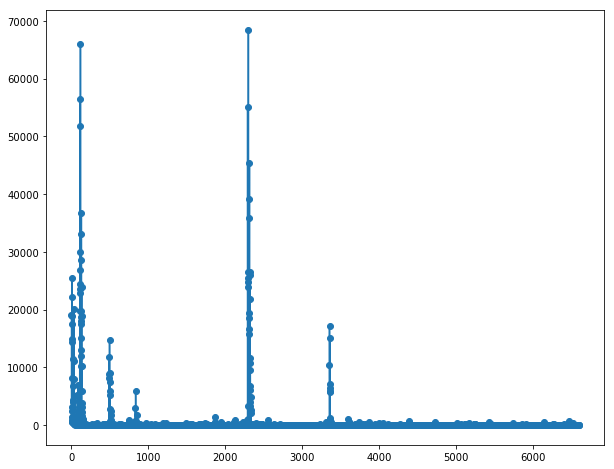

In [77]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(model.loss_history)), model.loss_history, '-o')
plt.plot()

14
0.976786 0.976175 0.954866


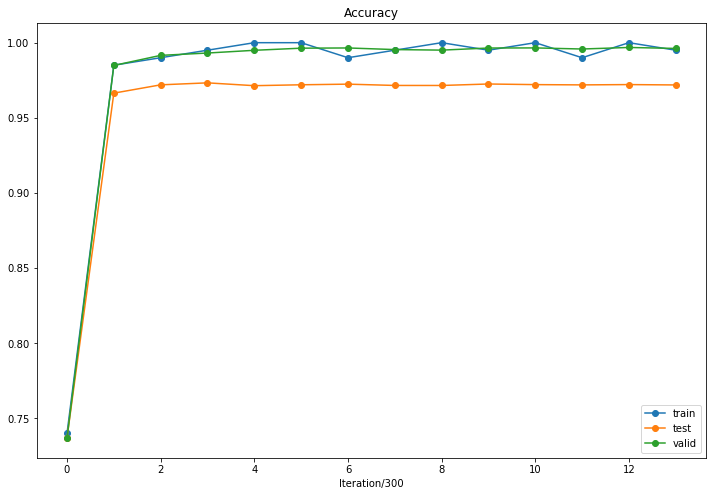

In [78]:
plt_len = len(model.train_acc_history)
print plt_len
print np.mean(model.train_acc_history), np.mean(model.val_acc_history), np.mean(model.test_acc_history)
plt.subplot(1,1,1)
plt.title('Accuracy')
plt.plot(model.train_acc_history, '-o', label='train')
plt.plot(model.test_acc_history, '-o', label='test')
plt.plot(model.val_acc_history, '-o', label='valid')
# plt.plot([90] * plt_len, 'k--')
plt.xlabel('Iteration/300')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(12,8)
plt.show()

## Analysis

In [108]:
def getConfusionMatrix(y_true, y_pred, header):
    m = len(set(y_true.flatten()))
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    mat = np.mat(np.zeros((m,m)))
    for real, pred in zip(y_true,y_pred):
        mat[real,pred] = mat[real,pred] + 1
    return pd.DataFrame(data=mat, index= header, columns=header, dtype=int)

In [112]:
y_pred = model.predict(data['X_test'])
confMatrix = getConfusionMatrix(data['y_test'], y_pred, ['normal', 'DOS'])
confMatrix

,normal,DOS
normal,59498,1094
DOS,6954,222899


In [24]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [79]:
#统计每个列别的precision TP/(TP + FN)检测率   Recall: TP/(TP + FP)对应误报率

#negative对应的是正常的，positive对应的是attack.以此转换成二分类问题
def precission_recall(predictions, actuals, negative=[0], positive=[1,2,3,4]):
    pred_labels = np.argmax(predictions,axis=1)
    actual_labels = np.argmax(actuals, axis=1)
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    test_size = predictions.shape[0]
    for i in xrange(test_size):
        if pred_labels[i] in positive:
            if actual_labels[i] in positive:
                TP += 1.0
            else:
                FP += 1.0
        else:
            if actual_labels[i] in negative:
                TN += 1.0
            else:
                FN += 1.0
    if TP + FN == 0:
        print 'There is no positive in test'
        precission = -1
    else:
        precission = TP / (TP + FN)
    if TP + FP == 0:
        print 'There is no positive in the prediction'
        recall = -1
    else:
        recall = TP / (TP + FP)
    return precission, recall

In [80]:
#normal: 0 PROBE:1 DOS:2 U2R:3 R2L:4 Positive:1-4攻击； Negative:0 正常；
last_test_pred = model.predict(data['X_test'])
last_test_pred_idx = np.argmax(last_test_pred, axis=1)
sub_test_idx = np.argmax(sub_test_labels.values[::],axis=1)
print last_test_pred_idx.shape, sub_test_idx.shape

precission, recall = precission_recall(last_test_pred, sub_test_labels.values[::], negative=[0], positive=[1])

print '检测率: %.2f%%' % (precission * 100)
print '误报率： %.2f%%' % (100 - recall * 100)

(290445,) (290445,)
检测率: 96.97%
误报率： 0.49%


In [81]:
print 'Test'
print len(sub_test_labels)
print '0:', np.sum(sub_test_labels.label_0 == 1)
# print '1:', np.sum(sub_test_labels.label_1 == 1)
print '2:', np.sum(sub_test_labels.label_2 == 1)
# print '3:', np.sum(sub_test_labels.label_3 == 1)
# print '4:', np.sum(sub_test_labels.label_4 == 1)

Test
290445
0: 60592
2: 229853


In [82]:
pred = np.argmax(last_test_pred, axis=1)
print 'Prediction'
print 'tot:', pred.shape[0]
print '0:', pred[pred==0].shape[0]
print '1:', pred[pred==1].shape[0]
# print '2:', pred[pred==2].shape[0]
# print '3:', pred[pred==3].shape[0]
# print '4:', pred[pred==4].shape[0]

Prediction
tot: 290445
0: 66452
1: 223993
